# Criando um Mini RAG com Dados Tabulares usando LightRAG

Neste notebook, vamos treinar um modelo **LightRAG** para responder perguntas sobre o dataset sintético [`clima_dataset.csv`](../data/clima_dataset.csv).

O objetivo é fazer o modelo responder a perguntas feitas em **linguagem natural** com base nos dados tabulares do dataset.

## 1. Importação das bibliotecas

Lembrete: Todos as bibliotecas necessárias para se ter no ambiente virtual estão no arquivo [`requirements.txt`](../requirements.txt)!

In [1]:
import os
import asyncio
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.asyncio import tqdm_asyncio
from lightrag import LightRAG, QueryParam
from lightrag.utils import EmbeddingFunc
from lightrag.kg.shared_storage import initialize_pipeline_status
from lightrag.llm.ollama import ollama_model_complete, ollama_embed

## 2. Instalar os modelos locais que vamos utilizar

O **LightRAG (HKU)** possui suporte nativo ao `Ollama`, permitindo o uso de modelos totalmente locais, sem necessidade de conexão com a internet.

Você pode conferir a lista de modelos disponíveis do [ollama](https://ollama.com/library/)

Para este exemplo, vamos instalar um modelo de embedding (para representar os textos numericamente) e um modelo de geração de texto (LLM).

💡 *Observação*: Também é possível utilizar outros modelos, como os da OpenAI, caso você possua uma API Key e prefira rodar em modo online.

Antes precisamos instalar o Ollama no terminal:
```bash
curl -fsSL https://ollama.com/install.sh | sh
```

Modelo de geração (LLM):
*O `gemma2:2b` é um modelo super leve (~1.6 GB)*
```bash
ollama pull gemma2:2b
```

Modelo de *embedding*:
*O `nomic-embed-text` é ótimo para RAG e bem leve (~120MB)*
```bash
ollama pull nomic-embed-text
```

Você pode testar os dois direto no terminal:

```bash
ollama run gemma2:2b

ollama run nomic-embed-text "O sol está brilhando sobre Recife."
```

Se ambos responderem, está tudo pronto.

Agora que os modelos estão instalados, podemos inicializar o **LightRAG** e começar a carregar nosso dataset tabular.

## 3. Carregar o dataset que será o core

In [2]:
DATA_DIR = "../data/clima_dataset.csv"

df = pd.read_csv(DATA_DIR)
df.head()

,City,Date,MaxTemperature,MinTemperature,Condition
0,Recife,2024-03-01,31,25,Sunny
1,Recife,2024-03-02,30,25,Cloudy
2,Recife,2024-03-03,29,24,Rainy
3,Recife,2024-03-04,28,23,Rainy
4,Recife,2024-03-05,30,24,Sunny


## 4. Inicializando o modelo do LightRAG e adicionando dados tabulares

Por padrão o `lightrag-hku` precisa da configuração de modelo de embedding e LLM definida.

Obs.:Este notebook usa um Grafo de Conhecimento pré-processado para evitar um tempo de espera longo na demonstração.

**Antes de continuar, faça o seguinte:**
1.  Encontre o arquivo `rag_storage.zip` no mesmo diretório deste notebook.
2.  **Descompacte-o aqui.** Você deve ter uma pasta chamada `rag_storage` ao lado deste arquivo.

Quando a pasta `rag_storage` estiver visível, você pode executar o restante do notebook.

In [ ]:
WORKING_DIR = "./rag_storage"
os.makedirs(WORKING_DIR, exist_ok=True)

# Função de formatação de linha → texto natural
def row_to_text(r):
    return (
        f"City: {r['City']}; "
        f"Date: {r['Date']}; "
        f"Max temperature: {r['MaxTemperature']}°C; "
        f"Min temperature: {r['MinTemperature']}°C; "
        f"Condition: {r['Condition']}."
    )
texts = df.apply(row_to_text, axis=1).tolist()

# Inicializando o LightRAG com modelos Ollama
rag = LightRAG(
    working_dir=WORKING_DIR,
    llm_model_func=ollama_model_complete,            # função de geração
    llm_model_name="gemma2:2b",                      # nome do modelo local no Ollama
    llm_model_kwargs={"options": {"num_ctx": 2048}}, # 2k tokens de contexto
    llm_model_max_async=1,                           # 1 worker LLM
    embedding_func_max_async=1,                      # 1 worker embedding

    # Função de embedding
    embedding_func=EmbeddingFunc(
        embedding_dim=768,  # dimensão padrão de embeddings do nomic-embed-text
        func=lambda texts: ollama_embed(
            texts,
            embed_model="nomic-embed-text",
            options={"num_thread": 2}
        )
    ),
    default_embedding_timeout=180,
)


# Inicializando os storages do RAG
await rag.initialize_storages()
await initialize_pipeline_status()

# Como já temos o grafo carregado no zip, podemos pular a etapa de construção do grafo.
print("✅ Grafo de conhecimento pré-processado carregado com sucesso do disco!")

# # Adicionando os dados tabulares ao RAG
# semaphore = asyncio.Semaphore(1)

# async def safe_insert(t):
#     async with semaphore:
#         try:
#             await rag.ainsert(t)
#         except Exception as e:
#             print(f"⚠️ Erro ao indexar item: {e}")

# print("📦 Inserindo dados tabulares no LightRAG...")
# await tqdm_asyncio.gather(
#     *(safe_insert(t) for t in texts),
#     total=len(texts),
#     desc="Indexando linhas"
# )
# print("✅ Dataset indexado com sucesso!")

INFO: [_] Created new empty graph file: ./rag_storage/graph_chunk_entity_relation.graphml
INFO:nano-vectordb:Init {'embedding_dim': 768, 'metric': 'cosine', 'storage_file': './rag_storage/vdb_entities.json'} 0 data
INFO:nano-vectordb:Init {'embedding_dim': 768, 'metric': 'cosine', 'storage_file': './rag_storage/vdb_relationships.json'} 0 data
INFO:nano-vectordb:Init {'embedding_dim': 768, 'metric': 'cosine', 'storage_file': './rag_storage/vdb_chunks.json'} 0 data
INFO: [_] Process 112171 KV load full_docs with 0 records
INFO: [_] Process 112171 KV load text_chunks with 0 records
INFO: [_] Process 112171 KV load full_entities with 0 records
INFO: [_] Process 112171 KV load full_relations with 0 records
INFO: [_] Process 112171 KV load entity_chunks with 0 records
INFO: [_] Process 112171 KV load relation_chunks with 0 records
INFO: [_] Process 112171 KV load llm_response_cache with 0 records
INFO: [_] Process 112171 doc status load doc_status with 0 records


✅ Grafo de conhecimento pré-processado carregado com sucesso do disco!
📦 Inserindo dados tabulares no LightRAG...


Indexando linhas:   0%|          | 0/50 [00:00<?, ?it/s]INFO: Processing 1 document(s)
INFO: Extracting stage 1/1: unknown_source
INFO: Processing d-id: doc-b0623d03e3b22d1b2d7e39cb0ee59638
INFO: Embedding func: 1 new workers initialized (Timeouts: Func: 180s, Worker: 360s, Health Check: 375s)
INFO: LLM func: 1 new workers initialized (Timeouts: Func: 180s, Worker: 360s, Health Check: 375s)
INFO:  == LLM cache == saving: default:extract:b01bdc48e2ad8094b57a493480012544
INFO:  == LLM cache == saving: default:extract:788bdbc08dfd5f9147d709c42f73f820
INFO: Chunk 1 of 1 extracted 0 Ent + 0 Rel chunk-b0623d03e3b22d1b2d7e39cb0ee59638
INFO: Merging stage 1/1: unknown_source
INFO: Phase 1: Processing 0 entities from doc-b0623d03e3b22d1b2d7e39cb0ee59638 (async: 2)
INFO: Phase 2: Processing 0 relations from doc-b0623d03e3b22d1b2d7e39cb0ee59638 (async: 2)
INFO: Phase 3: Updating final 0(0+0) entities and  0 relations from doc-b0623d03e3b22d1b2d7e39cb0ee59638
INFO: Completed merging: 0 entities, 0

✅ Dataset indexado com sucesso!


## 5. Fazendo perguntas em linguagem natural

In [4]:
pergunta_1 = "Which city had the highest maximum temperature recorded?"
pergunta_2 = "In which city did it rain the most days?"
pergunta_3 = "How was the weather like in Recife on March 5th?"

for pergunta in [pergunta_1, pergunta_2, pergunta_3]:
    print(f"> [P]: {pergunta}\n")
    resposta = await rag.aquery(pergunta)
    print(f"\n> [R]: {resposta}\n")

> [P]: Which city had the highest maximum temperature recorded?



INFO:  == LLM cache == saving: mix:keywords:50cbd5c687c5591eeccdcf5e327f541e
INFO: Query nodes: temperature, maximum, city, record (top_k:40, cosine:0.2)
INFO: Local query: 4 entites, 2 relations
INFO: Query edges: city temperatures, highest maximum temperature (top_k:40, cosine:0.2)
INFO: Global query: 3 entites, 2 relations
INFO: Naive query: 20 chunks (chunk_top_k:20 cosine:0.2)
INFO: Raw search results: 4 entities, 2 relations, 20 vector chunks
INFO: After truncation: 4 entities, 2 relations
INFO: Selecting 6 from 6 entity-related chunks by vector similarity
INFO: Find no additional relations-related chunks from 2 relations
INFO: Round-robin merged chunks: 26 -> 21 (deduplicated 5)
INFO: Final context: 4 entities, 2 relations, 20 chunks
INFO: Final chunks S+F/O: E1/1 C1/2 E2/2 C1/3 E2/3 E1/4 C1/5 E2/5 C1/6 E1/6 C1/7 C1/8 C1/9 C1/10 C1/12 C1/13 C1/14 C1/17 C1/18 C1/19
INFO:  == LLM cache == saving: mix:query:4bda6d09610a41c5c791b7c6a6560fd6



> [R]: The city with the highest maximum temperature recorded was Manaus, at 35°C. 
 
### References

- [1] Document Title One 
- [2] Document Title Two
- [3] Document Title Three 




> [P]: In which city did it rain the most days?



INFO:  == LLM cache == saving: mix:keywords:b83963fefbc8e6dda07b01aa9e9bbfd6
INFO: Query nodes: Rain, City name (top_k:40, cosine:0.2)
INFO: Local query: 4 entites, 2 relations
INFO: Query edges: Rainy days, Cities, Weather patterns (top_k:40, cosine:0.2)
INFO: Global query: 3 entites, 2 relations
INFO: Naive query: 20 chunks (chunk_top_k:20 cosine:0.2)
INFO: Raw search results: 4 entities, 2 relations, 20 vector chunks
INFO: After truncation: 4 entities, 2 relations
INFO: Selecting 6 from 6 entity-related chunks by vector similarity
INFO: Find no additional relations-related chunks from 2 relations
INFO: Round-robin merged chunks: 26 -> 23 (deduplicated 3)
INFO: Final context: 4 entities, 2 relations, 20 chunks
INFO: Final chunks S+F/O: C1/1 E2/1 C1/2 E1/2 C1/3 E2/3 C1/4 E1/4 C1/5 E2/5 C1/6 E1/6 C1/8 C1/9 C1/10 C1/11 C1/12 C1/13 C1/14 C1/15
INFO:  == LLM cache == saving: mix:query:f6e3bfecc79c8444a9b37b06d39eb880



> [R]: Based on the provided information, the city that experienced the highest number of rainy days is **Fortaleza**.  The document chunks state the following for Fortaleza: 

* City: Fortaleza; Date: 2024-03-01; Max temperature: 33°C; Min temperature: 26°C; Condition: Cloudy.
* City: Fortaleza; Date: 2024-03-03; Max temperature: 31°C; Min temperature: 26°C; Condition: Rainy.
* City: Fortaleza; Date: 2024-03-07; Max temperature: 31°C; Min temperature: 25°C; Condition: Rainy.





> [P]: How was the weather like in Recife on March 5th?



INFO:  == LLM cache == saving: mix:keywords:da61199507c12f005c63c7183c26de50
INFO: Query nodes: March 5th (top_k:40, cosine:0.2)
INFO: Local query: 4 entites, 2 relations
INFO: Query edges: weather, Recife (top_k:40, cosine:0.2)
INFO: Global query: 3 entites, 2 relations
INFO: Naive query: 20 chunks (chunk_top_k:20 cosine:0.2)
INFO: Raw search results: 4 entities, 2 relations, 20 vector chunks
INFO: After truncation: 4 entities, 2 relations
INFO: Selecting 6 from 6 entity-related chunks by vector similarity
INFO: Find no additional relations-related chunks from 2 relations
INFO: Round-robin merged chunks: 26 -> 26 (deduplicated 0)
INFO: Final context: 4 entities, 2 relations, 20 chunks
INFO: Final chunks S+F/O: C1/1 E1/1 C1/2 E2/2 C1/3 E1/3 C1/4 E2/4 C1/5 E1/5 C1/6 E2/6 C1/7 C1/8 C1/9 C1/10 C1/11 C1/12 C1/13 C1/14
INFO:  == LLM cache == saving: mix:query:0853c030d3269a3fc0cb73a8dac9a9e2



> [R]: Recife experienced sunny weather on March 5th. The maximum temperature reached 30°C, while the minimum temperature was 26°C. 


### References

- [1] Document Title One 




### 5.1 Uma das alternativas para melhorar o desempenho do RAG é utilizando instruções através da própria pergunta.

In [5]:
for pergunta in [pergunta_1, pergunta_2, pergunta_3]:
    print(f"> [P]: {pergunta}\n")

    pergunta_instruida = (
        "Use only the provided data to answer the question. "
        "Do not use external knowledge. "
        "If the answer is not in the data, say: "
        "'I could not find this information in the provided data.'\n\n"
        f"Question: {pergunta}"
    )

    resposta = await rag.aquery(pergunta_instruida)
    print(f"\n> [R]: {resposta}\n")

> [P]: Which city had the highest maximum temperature recorded?



INFO:  == LLM cache == saving: mix:keywords:1c716d72983f4bf38a006bc3a5b87389
INFO: Query edges: city, temperature, maximum (top_k:40, cosine:0.2)
INFO: Global query: 3 entites, 2 relations
INFO: Naive query: 20 chunks (chunk_top_k:20 cosine:0.2)
INFO: Raw search results: 3 entities, 2 relations, 20 vector chunks
INFO: After truncation: 3 entities, 2 relations
INFO: Selecting 3 from 3 entity-related chunks by vector similarity
INFO: Find no additional relations-related chunks from 2 relations
INFO: Round-robin merged chunks: 23 -> 20 (deduplicated 3)
INFO: Final context: 3 entities, 2 relations, 20 chunks
INFO: Final chunks S+F/O: C1/1 E2/1 C1/2 E2/2 C1/3 E2/3 C1/4 C1/6 C1/7 C1/8 C1/9 C1/10 C1/11 C1/12 C1/14 C1/15 C1/16 C1/17 C1/19 C1/20
INFO:  == LLM cache == saving: mix:query:cf6f93d011f9373b190074f5fb79eacb



> [R]: Manaus had the highest recorded maximum temperature of 35°C.  


> [P]: In which city did it rain the most days?



INFO:  == LLM cache == saving: mix:keywords:977cf49b991b6c021f10825dbfc9662b
INFO: Query edges: City, Rainfall, Weather patterns (top_k:40, cosine:0.2)
INFO: Global query: 3 entites, 2 relations
INFO: Naive query: 20 chunks (chunk_top_k:20 cosine:0.2)
INFO: Raw search results: 3 entities, 2 relations, 20 vector chunks
INFO: After truncation: 3 entities, 2 relations
INFO: Selecting 3 from 3 entity-related chunks by vector similarity
INFO: Find no additional relations-related chunks from 2 relations
INFO: Round-robin merged chunks: 23 -> 22 (deduplicated 1)
INFO: Final context: 3 entities, 2 relations, 20 chunks
INFO: Final chunks S+F/O: C1/1 E2/1 C1/2 E2/2 C1/3 E2/3 C1/4 C1/5 C1/6 C1/8 C1/9 C1/10 C1/11 C1/12 C1/13 C1/14 C1/15 C1/16 C1/17 C1/18
INFO:  == LLM cache == saving: mix:query:207eab358b0dd50197e58bed32b78178



> [R]: I could not find this information in the provided data. 


### References


> [P]: How was the weather like in Recife on March 5th?



INFO:  == LLM cache == saving: mix:keywords:445a442c71c992aab6b81bb6b2b06e42
INFO: Query edges: weather, Recife, March 5th (top_k:40, cosine:0.2)
INFO: Global query: 3 entites, 2 relations
INFO: Naive query: 20 chunks (chunk_top_k:20 cosine:0.2)
INFO: Raw search results: 3 entities, 2 relations, 20 vector chunks
INFO: After truncation: 3 entities, 2 relations
INFO: Selecting 3 from 3 entity-related chunks by vector similarity
INFO: Find no additional relations-related chunks from 2 relations
INFO: Round-robin merged chunks: 23 -> 22 (deduplicated 1)
INFO: Final context: 3 entities, 2 relations, 20 chunks
INFO: Final chunks S+F/O: C1/1 E2/1 C1/2 E2/2 C1/3 E2/3 C1/4 C1/5 C1/6 C1/7 C1/8 C1/9 C1/10 C1/11 C1/12 C1/13 C1/14 C1/15 C1/16 C1/17
INFO:  == LLM cache == saving: mix:query:2efb14fec313153975519c7bcd7df592



> [R]: City: Recife; Date: 2024-03-05; Max temperature: 30°C; Min temperature: 24°C; Condition: Cloudy. 


### References

- [1]  Document Title One 
- [2] Document Title Two 







### 5.2 Outra alternativa é usando o "QueryParam" para mudar o modo que o LightRAG vai trabalhar na query

In [6]:
params = QueryParam(mode="mix", enable_rerank=False)

for pergunta in [pergunta_1, pergunta_2, pergunta_3]:
    print(f"> [P]: {pergunta}\n")
    resposta = await rag.aquery(pergunta, param=params)
    print(f"\n> [R]: {resposta}\n")

INFO: Query nodes: temperature, maximum, city, record (top_k:40, cosine:0.2)


> [P]: Which city had the highest maximum temperature recorded?



INFO: Local query: 4 entites, 2 relations
INFO: Query edges: city temperatures, highest maximum temperature (top_k:40, cosine:0.2)
INFO: Global query: 3 entites, 2 relations
INFO: Naive query: 20 chunks (chunk_top_k:20 cosine:0.2)
INFO: Raw search results: 4 entities, 2 relations, 20 vector chunks
INFO: After truncation: 4 entities, 2 relations
INFO: Selecting 6 from 6 entity-related chunks by vector similarity
INFO: Find no additional relations-related chunks from 2 relations
INFO: Round-robin merged chunks: 26 -> 21 (deduplicated 5)
INFO: Final context: 4 entities, 2 relations, 20 chunks
INFO: Final chunks S+F/O: E1/1 C1/2 E2/2 C1/3 E2/3 E1/4 C1/5 E2/5 C1/6 E1/6 C1/7 C1/8 C1/9 C1/10 C1/12 C1/13 C1/14 C1/17 C1/18 C1/19
INFO:  == LLM cache == saving: mix:query:fb9c2eae9a6a6641b097f449c26330ab
INFO: Query nodes: Rain, City name (top_k:40, cosine:0.2)



> [R]: The highest maximum temperature recorded was 35°C in Manaus. 


> [P]: In which city did it rain the most days?



INFO: Local query: 4 entites, 2 relations
INFO: Query edges: Rainy days, Cities, Weather patterns (top_k:40, cosine:0.2)
INFO: Global query: 3 entites, 2 relations
INFO: Naive query: 20 chunks (chunk_top_k:20 cosine:0.2)
INFO: Raw search results: 4 entities, 2 relations, 20 vector chunks
INFO: After truncation: 4 entities, 2 relations
INFO: Selecting 6 from 6 entity-related chunks by vector similarity
INFO: Find no additional relations-related chunks from 2 relations
INFO: Round-robin merged chunks: 26 -> 23 (deduplicated 3)
INFO: Final context: 4 entities, 2 relations, 20 chunks
INFO: Final chunks S+F/O: C1/1 E2/1 C1/2 E1/2 C1/3 E2/3 C1/4 E1/4 C1/5 E2/5 C1/6 E1/6 C1/8 C1/9 C1/10 C1/11 C1/12 C1/13 C1/14 C1/15
INFO:  == LLM cache == saving: mix:query:e2b7b5b16baa30ffc3932cdfdc74670e
INFO: Query nodes: March 5th (top_k:40, cosine:0.2)
INFO: Local query: 4 entites, 2 relations
INFO: Query edges: weather, Recife (top_k:40, cosine:0.2)
INFO: Global query: 3 entites, 2 relations
INFO: Naive 


> [R]: Based on the provided data, Manaus had the most rainy days.  

### References

- [1] Document Title One 


> [P]: How was the weather like in Recife on March 5th?



INFO: Find no additional relations-related chunks from 2 relations
INFO: Round-robin merged chunks: 26 -> 26 (deduplicated 0)
INFO: Final context: 4 entities, 2 relations, 20 chunks
INFO: Final chunks S+F/O: C1/1 E1/1 C1/2 E2/2 C1/3 E1/3 C1/4 E2/4 C1/5 E1/5 C1/6 E2/6 C1/7 C1/8 C1/9 C1/10 C1/11 C1/12 C1/13 C1/14
INFO:  == LLM cache == saving: mix:query:b0470a09d92849bf3548d3dd4e26cc2f



> [R]: The weather in Recife on March 5th was described as sunny. The maximum temperature was 30°C and the minimum temperature was 24°C. 


### References

- [1] Document Title One 
  * This document contains information about Recife's weather on March 5, including details like the high and low temperatures and whether it was sunny. 







## 6. Grafo salvo no `rag_storage/`

É possível visualizar o **grafo** e os **embeddings** da `rag_storage/`

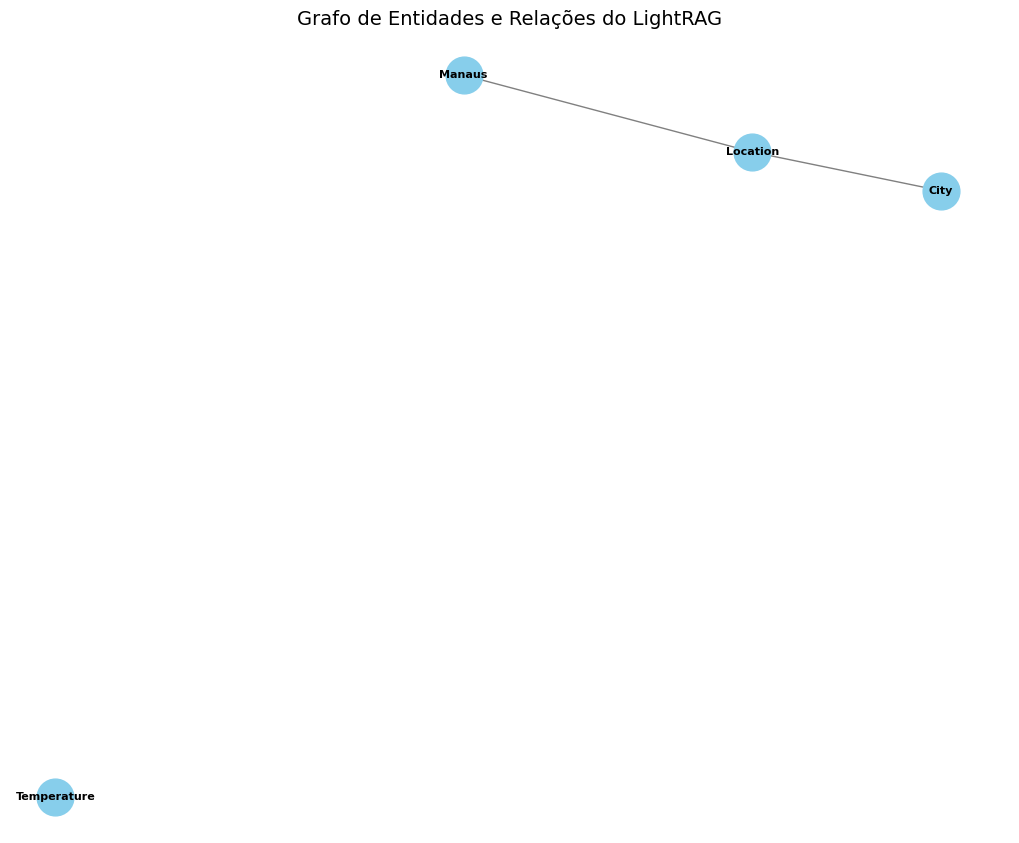

In [7]:
# Carrega o grafo do LightRAG
graph_path = "./rag_storage/graph_chunk_entity_relation.graphml"
G = nx.read_graphml(graph_path)

# Ajusta o tamanho e layout
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, k=0.5)

# Desenha os nós e arestas
nx.draw(
    G, pos,
    with_labels=True,
    node_color="skyblue",
    node_size=700,
    font_size=8,
    edge_color="gray",
    font_weight="bold"
)

plt.title("Grafo de Entidades e Relações do LightRAG", fontsize=14)
plt.show()